In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Slice Sampler in MCMC Algorithms

### Introduction

He'd heard stories that shredded documents could be reconstructed. All it took was patience: colossal patience.

--Ian Rankin, *Lets start*

While many of the MCMC algorithms presented in the previous chapter are both generic and universal, there exists a special class of MCMC algorithms that are more model-dependent. These algorithms exploit the local conditional features of the distributions to simulate. Before starting the general description of such algorithms, gathered under the name of **Gibbs sampling**, we provide a simpler introduction to these special kinds of MCMC algorithms. We reconsider the **Fundamental Theorem of Simulation** (Theorem 2.15) in light of the possibilities opened by MCMC methodology and construct the corresponding **slice sampler**.

## Another Look at the Fundamental Theorem

Recall from Section 2.3.1 that the generation from a distribution with density $ f(x) $ is equivalent to uniform generation on the subgraph of $ f $:

$$
\mathscr{S}(f) = \{(x, u);\, 0 \leq u \leq f(x)\},
$$

whatever the dimension of $ x $, and $ f $ need only be known up to a normalizing constant.

From the development at the beginning of Chapter 7, we can consider the possibility of using a Markov chain with stationary distribution equal to this uniform distribution on $ \mathscr{S}(f) $ as an approximate way to simulate from $ f $. A natural solution is to use a **random walk** on $ \mathscr{S}(f) $, since a random walk on a set $ \mathscr{A} $ usually results in a stationary distribution that is the uniform distribution on $ \mathscr{A} $.

## Implementing the Random Walk

There are many ways of implementing a random walk on this set, but a natural solution is to go one direction at a time, that is, to move iteratively along the $ u $-axis and then along the $ x $-axis. Furthermore, we can use uniform moves on both directions, since the associated Markov chain on $ \mathscr{S}(f) $ does not require a Metropolis-Hastings correction to have the uniform distribution on $ \mathscr{S}(f) $ as stationary distribution.

Starting from a point $ (x, u) $ in $ \{(x, u):\, 0 < u \leq f(x)\} $, the move along the $ u $-axis will correspond to the conditional distribution:

$$
U|X = x \sim \mathcal{U}(\{u: u \leq f(x)\}),
$$

resulting in a change from point $ (x, u) $ to point $ (x, u') $, still in $ \mathscr{S}(f) $, and then the move along the $ x $-axis to the conditional distribution:

$$
X|U = u' \sim \mathcal{U}(\{x: u' \leq f(x)\}),
$$

resulting in a change from point $ (x, u') $ to point $ (x', u') $.

## 2D Slice Sampler Algorithm

This set of proposals is the basis chosen for the original **slice sampler** of Neal (1997) and Damien et al. (1999), which thus uses a 2-step uniform random walk over the subgraph. We inaccurately call it the **2D slice sampler** to distinguish it from the general slice sampler defined in Section 8.2, even though the dimension of $ x $ is arbitrary.

**Algorithm A.31 - 2D Slice Sampler**

At iteration $ t $, simulate:

1. $ u^{(t+1)} \sim \mathcal{U}(0, f(x^{(t)})) $;
2. $ x^{(t+1)} \sim \mathcal{U}(A^{(t+1)}) $, with
   $$
   A^{(t+1)} = \{x: f(x) \geq u^{(t+1)}\}.
   $$

From (8.1) it is also clear that $ x^{(t)} $ is always part of the set $ A^{(t+1)} $, which is thus nonempty. Moreover, the algorithm remains valid if $ f(x) = \mathcal{O}_{f_1}(x) $, and we use $ f_1 $ instead of $ f $. This is quite advantageous in settings where $ f $ is an unnormalized density like a posterior density.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution (e.g., a Gaussian mixture model)
def target_distribution(x):
    return 0.3 * np.exp(-0.2 * (x - 2)**2) + 0.7 * np.exp(-0.2 * (x + 2)**2)

# 2D Slice Sampler Implementation
def slice_sampler(target, x_init, n_samples, burn_in):
    samples = []
    x = x_init
    
    for _ in range(n_samples + burn_in):
        # Step 1: Sample u uniformly from [0, f(x)]
        u = np.random.uniform(0, target(x))
        
        # Step 2: Sample x uniformly from the set {x: f(x) >= u}
        # This is done by finding the interval where f(x) >= u
        # For simplicity, we use a stepping-out procedure
        lower = x - 1.0
        upper = x + 1.0
        while target(lower) >= u:
            lower -= 1.0
        while target(upper) >= u:
            upper += 1.0
        
        # Sample x uniformly from the interval [lower, upper]
        x = np.random.uniform(lower, upper)
        
        # Check if the new x satisfies f(x) >= u
        while target(x) < u:
            if x < x_init:
                lower = x
            else:
                upper = x
            x = np.random.uniform(lower, upper)
        
        # Store the sample after burn-in period
        if _ >= burn_in:
            samples.append(x)
    
    return np.array(samples)

# Parameters
x_init = 0.0  # Initial value
n_samples = 10000  # Number of samples
burn_in = 1000  # Burn-in period

# Run the slice sampler
samples = slice_sampler(target_distribution, x_init, n_samples, burn_in)

# Plot the results
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Sampled Distribution')
x_values = np.linspace(-6, 6, 1000)
plt.plot(x_values, target_distribution(x_values), 'r', label='Target Distribution')
plt.title('2D Slice Sampler')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
import random
import math
import matplotlib.pyplot as plt

# Define the target distribution (e.g., a Gaussian mixture model)
def target_distribution(x):
    return 0.3 * math.exp(-0.2 * (x - 2)**2) + 0.7 * math.exp(-0.2 * (x + 2)**2)

# 2D Slice Sampler Implementation
def slice_sampler(target, x_init, n_samples, burn_in):
    samples = []
    x = x_init
    
    for _ in range(n_samples + burn_in):
        # Step 1: Sample u uniformly from [0, f(x)]
        u = random.uniform(0, target(x))
        
        # Step 2: Sample x uniformly from the set {x: f(x) >= u}
        # This is done by finding the interval where f(x) >= u
        # For simplicity, we use a stepping-out procedure
        lower = x - 1.0
        upper = x + 1.0
        while target(lower) >= u:
            lower -= 1.0
        while target(upper) >= u:
            upper += 1.0
        
        # Sample x uniformly from the interval [lower, upper]
        x = random.uniform(lower, upper)
        
        # Check if the new x satisfies f(x) >= u
        while target(x) < u:
            if x < x_init:
                lower = x
            else:
                upper = x
            x = random.uniform(lower, upper)
        
        # Store the sample after burn-in period
        if _ >= burn_in:
            samples.append(x)
    
    return samples

# Parameters
x_init = 0.0  # Initial value
n_samples = 10000  # Number of samples
burn_in = 1000  # Burn-in period

# Run the slice sampler
samples = slice_sampler(target_distribution, x_init, n_samples, burn_in)

# Plot the results
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Sampled Distribution')
x_values = [x * 0.1 for x in range(-60, 61)]
y_values = [target_distribution(x) for x in x_values]
plt.plot(x_values, y_values, 'r', label='Target Distribution')
plt.title('2D Slice Sampler')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

## MCMC Algorithm and Slice Sampling

This section discusses the validity of the slice sampler as an MCMC algorithm and provides examples of its application. The concepts are explained in detail with mathematical formulations and practical examples.

---

## Validity of [4.31]

As explained, [4.31] preserves the uniform distribution on the subgraph of $ f $. The steps are as follows:

1. $ x^{(t)} \sim f(x) $ and $ u^{(t)} \sim \mathcal{U}_{[0,f(x^{(t)})]} $, where
   $$
   (x^{(t)}, u^{(t)}) \sim f(x) \cdot \frac{\mathbb{I}_{[0, f(x)]}(u)}{f(x)} \propto \mathbb{I}_{0 \leq u \leq f(x)}.
   $$

2. If $ u^{(t+1)} \sim \mathcal{U}_{[0,f(x^{(t)})]} $, then
   $$
   (x^{(t+1)}, u^{(t+1)}) \sim f(x) \frac{\mathbb{I}_{0 \leq u \leq f(x)}}{f(x)} \mathbb{I}_{A^{(t+1)}}(x^{(t+1)})
   $$
   where $ A^{(t+1)} $ denotes the set of valid $ x $ at step $ t+1 $, given by:
   $$
   A^{(t+1)} = \{ x : u \leq f(x) \}.
   $$

Thus,
$$
(x^{(t+1)}, u^{(t+1)}) \sim C \int \mathbb{I}_{0 \leq u \leq f(x)} \frac{\mathbb{I}_{A^{(t+1)}}(x)}{\text{mes}(A^{(t+1)})} dx,
$$
leading to the uniform distribution on $ \mathcal{S}(f) $.

---

## Example.1: Simple Slice Sampler

The density $ f(x) $ is given as:
$$
f(x) = \frac{1}{2} e^{-\sqrt{x}}
$$
for $ x > 0 $. Sampling follows these steps:

1. Draw $ U \sim \mathcal{U}\left(0, \frac{1}{2} e^{-\sqrt{x}}\right) $.
2. Draw $ X \sim \mathcal{U}(0, \log[2u])^2 $.

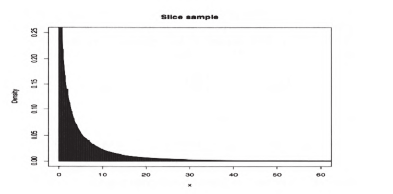


The histogram of 50,000 generated variates is shown in Fig.1. The performance of the slice sampler is excellent but can degrade for larger values of $ \sqrt{x} $.

---

## Example .2: Truncated Normal Distribution

For a truncated normal $ N^T(0, 1) $, restricted to the interval $ [0, 1] $, we compute:
$$
f(x) \propto \exp\left(-\frac{x^2 + 3}{2}\right) \mathbb{I}_{[0,1]}(x).
$$

The slice $ A^{(t+1)} $ is determined as:
$$
A^{(t+1)} = \{ y \in [0, 1] : (y + 3)^2 \leq -2 \log(u^{(t)}) \}.
$$

This generates an interval of the form $ [0, y^{(t)}] $.

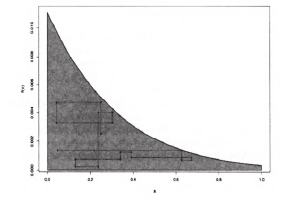

### Fig.2
The first ten steps starting from $ x^{(0)} = 0.25 $ illustrate the exploration of the support of $ f $.

---

## Key Observations

- The slice sampler effectively explores the subgraph of $ f $.
- The starting point influences the exploration rate for the truncated normal example, as seen in the trajectory variations in Figure 8.3.

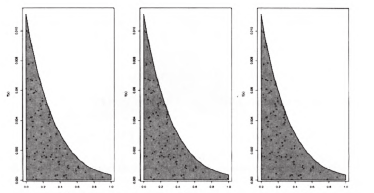


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target density f(x)
def f(x):
    return 0.5 * np.exp(-np.sqrt(x))

# Slice Sampling Implementation
def slice_sampler(f, x0, num_samples):
    samples = []
    x = x0
    for _ in range(num_samples):
        # Step 1: Draw a uniform height u
        u = np.random.uniform(0, f(x))
        
        # Step 2: Define the slice A = {x | f(x) >= u}
        # Solve for the boundaries of the slice
        x_min = 0  # lower bound
        x_max = (-np.log(2 * u))**2  # upper bound
        
        # Step 3: Sample a new point x from the slice
        x = np.random.uniform(x_min, x_max)
        
        # Store the sample
        samples.append(x)
    return np.array(samples)

# Parameters
x0 = 1.0  # Initial point
num_samples = 50000  # Number of samples

# Generate samples using the slice sampler
samples = slice_sampler(f, x0, num_samples)

# Plot results
x_vals = np.linspace(0, 10, 1000)
plt.figure(figsize=(10, 6))

# Plot histogram of samples
plt.hist(samples, bins=100, density=True, alpha=0.6, label="Slice Sampler")

# Overlay the target density
plt.plot(x_vals, f(x_vals), 'r-', lw=2, label="Target Density f(x)")

# Add labels and legend
plt.title("Slice Sampling Histogram and Target Density")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
import math
import random

# Define the target density f(x)
def f(x):
    return 0.5 * math.exp(-math.sqrt(x))

# Slice Sampling Implementation
def slice_sampler(f, x0, num_samples):
    samples = []  # List to store samples
    x = x0  # Initial point

    for _ in range(num_samples):
        # Step 1: Draw a uniform height u
        u = random.uniform(0, f(x))

        # Step 2: Define the slice bounds
        x_min = 0  # Lower bound of the slice
        x_max = (-math.log(2 * u))**2  # Upper bound of the slice

        # Step 3: Sample a new point x from the slice
        x = random.uniform(x_min, x_max)

        # Store the sample
        samples.append(x)

    return samples

# Parameters
x0 = 1.0  # Initial value for the sampler
num_samples = 10000  # Number of samples to generate

# Generate samples
samples = slice_sampler(f, x0, num_samples)

# Output some statistics
mean_sample = sum(samples) / len(samples)
std_dev_sample = math.sqrt(sum((x - mean_sample)**2 for x in samples) / len(samples))

print(f"Generated {num_samples} samples.")
print(f"Mean of samples: {mean_sample:.4f}")
print(f"Standard deviation of samples: {std_dev_sample:.4f}")
print(f"First 10 samples: {samples[:10]}")


## The General Slice Sampler

### Introduction
The general slice sampler provides an efficient way to handle higher-dimensional distributions by introducing auxiliary variables. This approach helps mitigate computational difficulties that arise when sampling directly from slices of the target density. The method decomposes the target density $ f(x) $ into a product of simpler components.

---

## Decomposition of the Density

The target density $ f(x) $ is expressed as:
$$
f(x) \propto \prod_{i=1}^k f_i(x),
$$
where each $ f_i(x) $ does not need to be a normalized density function. Instead, $ f_i(x) $ could represent factors such as individual likelihoods in Bayesian frameworks.

### Auxiliary Variables
To simplify sampling, the density $ f_i(x) $ can be written as:
$$
f_i(x) = \int_{0}^{S_i(x)} 1 \, du_i,
$$
where $ S_i(x) $ defines the slice for each component. The joint distribution is then given by:
$$
(x, u_1, \dots, u_k) \sim p(x, u_1, \dots, u_k) \propto \prod_{i=1}^k \mathbb{I}_{0 \leq u_i \leq S_i(x)}.
$$

This allows the sampler to perform updates one dimension at a time, effectively exploring the space.

---

## Algorithm A.32: Slice Sampler

1. At iteration $ t $, simulate $ u_i^{(t+1)} \sim \mathcal{U}(0, S_i(x^{(t)})) $ for $ i = 1, \dots, k $.
2. Simulate $ x^{(t+1)} \sim \mathcal{U}\left(\bigcap_{i=1}^k A_i^{(t+1)}\right) $, where:
   $$
   A_i^{(t+1)} = \{x : S_i(x) \geq u_i^{(t+1)}\}.
   $$

---

## Example .3: A 3D Slice Sampler

Consider the density proportional to:
$$
(1 + \sin^2(3x))(1 + \cos^2(5x)) \exp\left(-x^2 / 2\right).
$$

### Decomposition Functions
- $ f_1(x) = (1 + \sin^2(3x)) $,
- $ f_2(x) = (1 + \cos^2(5x)) $,
- $ f_3(x) = \exp(-x^2 / 2) $.

### Sampling Procedure
1. Generate three uniform random variables:
   $ u_1, u_2, u_3 \sim \mathcal{U}[0, 1] $.
2. The new value of $ x $ is uniformly distributed over the set:
   $$
   \{x : |x| \leq \sqrt{-2 \log u_3}\} \cap 
   \{x : \sin^2(3x) \geq 1 - u_1\} \cap 
   \{x : \cos^2(5x) \geq 1 - u_2\}.
   $$
   Depending on the values of $ u_1, u_2, $ and $ u_3 $, this interval may consist of multiple subintervals.

---

## Figure 8.4: Results

A histogram of samples generated by 5,000 iterations of the 3D slice sampler is shown. The overlaid curve represents the target density:
$$
(1 + \sin^2(3x))(1 + \cos^2(5x)) \exp\left(-x^2 / 2\right).
$$

---

## Application: Censored Data Models (Example .4)

In Section 5.3.1, the completion of censored data models is illustrated. Here, auxiliary variables are used in a latent representation. 

### Observations
Given $ y^r = (y_1^r, y_2^r) $ and the random variable $ r $, the observation $ y $ is censored by $ r $, and:
$$
y \sim f(y|r), \quad r \sim h(r).
$$
The data \( y^r \) is then:
$$
y^r = (y_i \land r, y_i^r).
$$



In [ ]:
import random
import math

# Define the target density functions
def f1(x):
    return 1 + math.sin(3 * x) ** 2

def f2(x):
    return 1 + math.cos(5 * x) ** 2

def f3(x):
    return math.exp(-x**2 / 2)

# Define the combined density function (not normalized)
def f(x):
    return f1(x) * f2(x) * f3(x)

# General Slice Sampling Implementation
def general_slice_sampler(f1, f2, f3, x0, num_samples):
    samples = []  # Store the samples
    x = x0  # Initial point
    
    for _ in range(num_samples):
        # Step 1: Generate auxiliary variables (uniformly distributed)
        u1 = random.uniform(0, f1(x))
        u2 = random.uniform(0, f2(x))
        u3 = random.uniform(0, f3(x))
        
        # Step 2: Determine the valid interval for x
        # Interval based on f1(x)
        def valid_f1(x):
            return 1 - u1 <= math.sin(3 * x) ** 2

        # Interval based on f2(x)
        def valid_f2(x):
            return 1 - u2 <= math.cos(5 * x) ** 2

        # Interval based on f3(x)
        def valid_f3(x):
            return abs(x) <= math.sqrt(-2 * math.log(u3))
        
        # Find valid x by random sampling in a large range (e.g., -10 to 10)
        while True:
            x_candidate = random.uniform(-10, 10)
            if valid_f1(x_candidate) and valid_f2(x_candidate) and valid_f3(x_candidate):
                x = x_candidate
                break

        # Store the sample
        samples.append(x)
    
    return samples

# Parameters
x0 = 0.0  # Initial value
num_samples = 5000  # Number of samples

# Run the sampler
samples = general_slice_sampler(f1, f2, f3, x0, num_samples)

# Analyze the results
mean_sample = sum(samples) / len(samples)
print(f"Generated {num_samples} samples.")
print(f"Mean of samples: {mean_sample:.4f}")
print(f"First 10 samples: {samples[:10]}")

# Optional: To plot the results, uncomment the following
# import matplotlib.pyplot as plt
# import numpy as np
# x_vals = np.linspace(-10, 10, 1000)
# plt.hist(samples, bins=50, density=True, alpha=0.7, label="Samples")
# plt.plot(x_vals, [f(x) for x in x_vals], 'r-', label="Target Density (scaled)")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("Density")
# plt.title("3D Slice Sampler")
# plt.show()


Here are all the equations from the image in LaTeX format:

$$(8.4) \int_{R_i}^{\infty} f(y|\theta) dy h(y_i^*) \mathbb{I}_{y_i=0} + \int_{R_i}^{\infty} h(z) dz f(y_i^*|\theta) \mathbb{I}_{y_i=1}$$

For posterior distribution with prior π:

$$\pi(\theta|y_1^*,...,y_n^*) \propto \pi(\theta) \prod_{(i:y_i=0)} \{h(y_i^*)\int_{R_i}^{\infty} f(y|\theta)dy\} \times \prod_{(i:y_i=1)} \{f(y_i^*|\theta)\int_{R_i}^{\infty} h(z)dz\}$$

Simplified as:

$$\propto \pi(\theta) \prod_{(i:y_i=0)} \int_{R_i}^{\infty} f(y|\theta)dy \prod_{(i:y_i=1)} f(y_i^*|\theta)$$

Marginal distribution:

$$\prod_{(i:y_i=0)} \{\mathbb{I}_{y_i\geq y_i^*}\mathbb{I}_{z\leq z_i f(y_i|\theta)}\} \prod_{(i:y_i=1)} \mathbb{I}_{z\leq z_i f(y_i^*|\theta)}$$

Set definition:

$$A^{(k+1)} = \{y: f_i(y) \geq z^{(k+1)}\}$$

# Posterior Distribution and Slice Sampling

## Introduction
In cases where the likelihood and posterior distribution are too complex to explicitly integrate, the slice sampling technique can be used effectively. This section elaborates on the use of auxiliary variables to simplify sampling in high-dimensional spaces.

---

## Posterior Distribution

Given the prior distribution $ \pi(\theta) $, the posterior distribution of $ \theta $ is given by:
$$
\pi(\theta \mid y_1^r, \dots, y_n^r) \propto \pi(\theta) \prod_{i=1}^n \left( f(y_i^r \mid \theta) \int_{y_i^r}^{+\infty} h(r) dr + \int_{-\infty}^{y_i^r} f(y \mid \theta) h(r) dr \right).
$$

This can be simplified further as:
$$
\pi(\theta \mid y_1^r, \dots, y_n^r) \propto \pi(\theta) \prod_{i=1}^n \int_{y_i^r}^{+\infty} f(y \mid \theta) dy,
$$
where $ f(y \mid \theta) $ is the likelihood function and $h(r) $ models the censoring process.

---

## Logical Completion for Uncensored Models

For uncensored models, the posterior distribution can be expressed as:
$$
\pi(\theta \mid y_1^r, \dots, y_n^r) \propto \pi(\theta) \prod_{i=1}^n f(y_i \mid \theta),
$$
where $ y_i $ are observed data points. In the presence of unobserved data $ y_u $, we decompose the posterior into observed and unobserved groups:
$$
\pi(\theta) \prod_{i \in \mathcal{I}_{\text{obs}}} f(y_i \mid \theta) \prod_{i \in \mathcal{I}_{\text{unobs}}} \int f(y \mid \theta) dy.
$$

At this level, we can introduce auxiliary variables $ u_i $ to further simplify the computations.

---

## Marginal Posterior Using Slice Sampling

The posterior distribution can now be written as:
$$
\pi(\theta) \prod_{i=1}^n \mathbb{I}_{0 \leq u_i \leq S_i(\theta)} \prod_{i=1}^n \mathbb{I}_{0 \leq S_i(\theta)}.
$$

Here, the slice $ S_i(\theta) $ is defined as:
$$
S_i(\theta) = \int f(y \mid \theta) dy.
$$

Adding $ u_i $ as auxiliary variables reduces the problem into simpler slices that can be sampled iteratively.

---

## Practical Considerations

1. **Dimensionality and Complexity**:
   As the dimensionality $ k $ of the target density increases, the determination of the slice $ A^{(t+1)} $ becomes computationally expensive.

2. **Efficiency Improvements**:
   Efficient proposals, such as those developed in Neal (2003), parallelize computations or simplify the geometry of the slices in high dimensions.

## Convergence Properties of the Slice Sampler

## Introduction

In this section, we explore the **convergence properties** of the slice sampler, a Markov Chain Monte Carlo (MCMC) method. These preliminary results are based on the work of **Roberts and Rosenthal (1998)** and focus on the conditions under which the slice sampler converges to the target distribution.

---

## Transition Kernel of the 2D Slice Sampler

For the 2D slice sampler defined by $ f_1(X^{(t+1)}) = v $, we denote $ \mu(w) $ as the **Lebesgue measure** of the set:
$$
\mathcal{S}(w) = \{ v : f_1(v) \geq w \}.
$$

The **transition kernel** is given by:
$$
\Pr \left( f_1(X^{(t+1)}) \leq f_1(X^{(t)}) = v \right) = \int_{v}^{\infty} \frac{\mu(S(t) \cap S(w))}{\mu(w)} \, dw,
$$
where $ S(w) $ is defined as the slice at level $ w $.

---

## Simplification of the Transition Kernel

Using the definition of $ \mu(w) $, the transition kernel simplifies to:
$$
\Pr \left( f_1(X^{(t+1)}) = v \right) = \frac{1}{\mu(w)} \int_{0}^{w} \mu(u) \, \max \left(1 - \frac{\mu(u)}{\mu(w)}, 0 \right) du.
$$

This characterization implies the **Markovian property** of the slice sampler, where $ X^{(t+1)} $ depends only on $ X^{(t)} $.

---

## Uniform Ergodicity

### Lemma 8.5
If $ f_1 $ is bounded and $ \text{sup } f_1 $ is finite, the slice sampler is **uniformly ergodic**.

#### Proof Sketch
1. Without loss of generality, assume $ f_1 $ is bounded by $ 1 $ and its support $ \mathcal{S}(w) $ is restricted to $ [0, 1] $.
2. Uniform ergodicity is established by:
   - Verifying Doeblin's condition:
     $$ 
     \zeta(v) = \Pr \left( f_1(X^{(t+1)}) \leq f_1(X^{(t)}) = v \right) > \epsilon \quad \text{for all } v.
     $$
   - Showing that $ \zeta(v) $ satisfies a small set condition for every $ v $.

### Implication
The slice sampler generates samples that converge uniformly to the target distribution under mild regularity conditions.

---

## Summary

- The **transition kernel** for the 2D slice sampler depends on the measure $ \mu(w) $, which represents the Lebesgue measure of the slice $ \mathcal{S}(w) $.
- Under boundedness conditions, the slice sampler is **uniformly ergodic**, ensuring convergence to the target distribution.



In [ ]:
import math

# Function f1(x): Example density function (replace with your target density if needed)
def f1(x):
    if x > 0:  # Define support of f1(x)
        return math.exp(-x)  # Example: Exponential distribution
    return 0

# Drift function V(r)
def drift_function(r, beta):
    return f1(r) ** -beta

# Compute KV(x): Transition kernel with drift condition
def compute_KV(x, beta, alpha, c_star):
    # Precompute constants for efficiency
    one_minus_beta = 1 - beta
    one_plus_alpha_beta = 1 + alpha * beta
    max_w = f1(x)

    # Integration over slices: Outer integral over ω (discretized for simplicity)
    step_size = 0.01  # Step size for numerical integration
    KV = 0
    w = step_size
    while w <= max_w:  # Outer integral
        # Inner integral over z
        z_integral = 0
        z = c_star
        while z <= x:  # Discretized inner integral
            z_integral += drift_function(z, beta) * step_size
            z += step_size

        # Add weighted contribution from inner integral
        KV += z_integral * step_size / w
        w += step_size

    # Add drift condition scaling
    KV = KV / f1(x)
    V_x = drift_function(x, beta)
    lambda_constant = (V_x / (one_minus_beta * one_plus_alpha_beta)) + \
                      (alpha * beta * c_star ** -beta / one_plus_alpha_beta)

    return KV, lambda_constant

# Verify the drift condition
def verify_drift_condition(x_values, beta, alpha, c_star):
    results = []
    for x in x_values:
        KV, lambda_constant = compute_KV(x, beta, alpha, c_star)
        satisfied = KV <= lambda_constant
        results.append((x, KV, lambda_constant, satisfied))
    return results

# Example usage
if __name__ == "__main__":
    # Parameters for drift condition
    beta = 0.5  # Choose beta < min(a-1, 1)/alpha
    alpha = 2   # Example alpha
    c_star = 0.1  # Minimum slice threshold

    # Range of x values to evaluate
    x_values = [i * 0.1 for i in range(1, 20)]  # From 0.1 to 2.0

    # Compute and verify drift condition
    results = verify_drift_condition(x_values, beta, alpha, c_star)

    # Display results
    print("x\tKV(x)\tLambda\tCondition Satisfied?")
    for x, KV, Lambda, satisfied in results:
        print(f"{x:.2f}\t{KV:.4f}\t{Lambda:.4f}\t{str(satisfied)}")


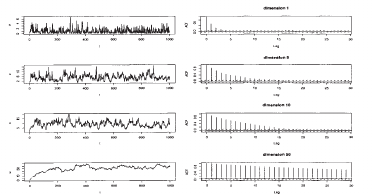
# Slice Sampler Analysis for Exponential and Poor Performance Cases

This notebook explores the properties of the **slice sampler** in two specific cases: 
1. The **Exponential Distribution** $ \text{Exp}(1) $, demonstrating its geometric ergodicity.  
2. A **poorly performing slice sampler** in high dimensions as illustrated by the autocorrelation behavior for $ f_1(z) \propto z^{d-1}e^{-z} $.  

### Example .8: Exponential Distribution $ \text{Exp}(1) $

The exponential distribution is defined as:

$$
f(x) = \exp(-x), \quad x > 0.
$$

The total variation distance between $ K^n $ and $ f $ satisfies the inequality for $ n \geq 23 $:

$$
\|K^n(x, \cdot) - f\|_{TV} \leq 0.54865(0.985051)^n.
$$

This indicates **geometric convergence** to the stationary distribution.

---

### Example.9: Poorly Performing Slice Sampler

For high-dimensional settings, consider the density:

$$
f(x) \propto \exp(-\|x\|), \quad x \in \mathbb{R}^d,
$$

where $ \|x\| $ is the Euclidean norm. In terms of the radius $ z = \|x\| $, the density can be rewritten as:

$$
\eta_d(z) \propto z^{d-1}e^{-z}, \quad z > 0.
$$

This transformation leads to the corresponding slice sampler density:

$$
\pi_d(u) \propto u^{1/d - 1}, \quad u \in (0, 1).
$$

As $ d $ increases:
- The slice sampler degenerates.
- The **mixing rate** slows down significantly.
- Autocorrelation increases, indicating poor sampling efficiency.

---

## Fig.5: Raw Plots and Autocorrelation Analysis

Below are raw plots and autocorrelation functions for the series $ z^{(t)} $ generated by the slice sampler for different dimensions $( d = 1, 5, 10, 50 $).




In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import random

# Slice sampler function
def slice_sampler(d, n_samples):
    """
    Simulates the slice sampler for z^(t) in the density z^(d-1) * exp(-z).
    Parameters:
        d (int): Dimension of the sampler.
        n_samples (int): Number of samples to generate.
    Returns:
        list: Generated samples.
    """
    samples = []
    z = random.uniform(0.1, 10)  # Initialize z^(0)
    for _ in range(n_samples):
        # Sample u from Uniform(0, f(z))
        u = random.uniform(0, z**(d-1) * math.exp(-z))
        
        # Define slice for z and sample from it
        z_lower = 0
        z_upper = 100  # Arbitrary large value for upper limit
        while True:
            z_new = random.uniform(z_lower, z_upper)
            if u <= z_new**(d-1) * math.exp(-z_new):
                z = z_new
                break
        samples.append(z)
    return samples

# Parameters for the simulation
dimensions = [1, 5, 10, 50]
n_samples = 1000

# Generate samples and plot results
plt.figure(figsize=(12, 8))
for i, d in enumerate(dimensions):
    samples = slice_sampler(d, n_samples)
    
    # Plot raw sample traces
    plt.subplot(2, len(dimensions), i + 1)
    plt.plot(samples, label=f"d = {d}")
    plt.title(f"Trace Plot (d={d})")
    plt.xlabel("Iteration")
    plt.ylabel("z^(t)")
    plt.legend()
    
    # Compute and plot autocorrelation
    plt.subplot(2, len(dimensions), i + 1 + len(dimensions))
    autocorr = [sum((samples[t] - sum(samples) / n_samples) * (samples[t + lag] - sum(samples) / n_samples)
                   for t in range(n_samples - lag)) / (n_samples - lag)
                for lag in range(50)]
    plt.plot(autocorr, label=f"d = {d}")
    plt.title(f"Autocorrelation (d={d})")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()

plt.tight_layout()
plt.show()
